In [2]:
import subprocess
import shlex
import pandas as pd
import numpy as np
from astropy.table import Table
from astropy.table import Column
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MultipleLocator
import glob
from matplotlib import pyplot
import matplotlib.gridspec as gridspec
import gc

In [2]:
basedir = "/home/xhall/Documents/"

sample200 = Table.from_pandas(pd.read_csv(basedir + "NewZTF/ML_sample_snid200.csv"))
ML_sample_snid_examples = Table.from_pandas(pd.read_csv(basedir + "NewZTF/ML_sample_snid_brightexamples.csv"))
sample_2018 = Table.from_pandas(pd.read_csv(basedir + "NewZTF/sample_2018/ML_sample_snid_norepeat_2018.csv"))
sample_2020 = Table.from_pandas(pd.read_csv("/home/xhall/Documents/NewZTF/sample_2020/SNID_2020_output.csv"))
sample_remaining = Table.from_pandas(pd.read_csv("/home/xhall/Documents/ZTFI/SNID_2020_remaining_output.csv"))

In [1]:
superfit_results = Table.from_pandas(pd.read_csv(r"C:\Users\20xha\Documents\Superfit\superfit_classes.csv"))

NameError: name 'Table' is not defined

In [3]:
sample_remaining

Version,ZTF_Name,z_sntemplate,z_rlap,z_snid,z_snid_err,z_level,rank_1,sntemplate_1,rlap_1,c_snid_1,z_snid_1,z_snid_err_1,age_1,age_flag_1,rank_2,sntemplate_2,rlap_2,c_snid_2,z_snid_2,z_snid_err_2,age_2,age_flag_2,rank_3,sntemplate_3,rlap_3,c_snid_3,z_snid_3,z_snid_err_3,age_3,age_flag_3,rank_4,sntemplate_4,rlap_4,c_snid_4,z_snid_4,z_snid_err_4,age_4,age_flag_4,rank_5,sntemplate_5,rlap_5,c_snid_5,z_snid_5,z_snid_err_5,age_5,age_flag_5
str39,str12,str12,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64
ZTF18aaabltn_20201015_DCT_v1.ascii,ZTF18aaabltn,agn,41.0,0.0458,0.0007,1,1,agn,41.0,AGN,0.0458,0.0007,-99.9,2,2,qso,35.2,QSO,0.0459,0.0007,-100.0,2,3,sn06bc,17.33,II-norm,0.0453,0.0013,9.0,0,4,kcSB3,15.41,Gal,0.0465,0.0014,-99.9,2,5,kcSB5,13.73,Gal,0.0459,0.0016,-99.9,2
ZTF18aaaehwv_20200917_P60_v1.ascii,ZTF18aaaehwv,kcSa,4.0,0.6678,0.0075,0,1,kcSa,4.0,Gal,0.6678,0.0075,-99.9,2,2,sn2011dh,3.91,IIb,0.9447,0.0091,-8.6,0,3,sn02ap,3.71,Ic-BL,0.6906,0.0096,234.1,0,4,sn2002er,3.57,Ia-norm,0.7053,0.0097,4.9,0,6,sn2007bi,3.52,Ic-SLSN,0.7061,0.0127,53.64,0
ZTF18aadsuxd_20201103_P60_v1.ascii,ZTF18aadsuxd,kcSB2,14.87,0.0293,0.0017,1,1,kcSB2,14.87,Gal,0.0293,0.0017,-99.9,2,2,kcSB1,14.8,Gal,0.0296,0.0016,-99.9,2,3,kcSB4,12.8,Gal,0.0291,0.0018,-99.9,2,8,agn,7.79,AGN,0.0293,0.0035,-99.9,2,9,PS1-10bzj,7.02,Ic-SLSN,0.0313,0.0033,15.64,0
ZTF18aadsuxd_20201110_P60_v1.ascii,ZTF18aadsuxd,kcSB2,14.6,0.0302,0.0018,1,1,kcSB2,14.6,Gal,0.0302,0.0018,-99.9,2,2,kcSB1,13.69,Gal,0.0305,0.0018,-99.9,2,3,kcSc,12.42,Gal,0.0302,0.002,-99.9,2,5,PS1-10bzj,9.83,Ic-SLSN,0.0308,0.0028,6.55,0,9,agn,7.44,AGN,0.0301,0.0037,-99.9,2
ZTF18aadvsxy_20200921_P60_v1.ascii,ZTF18aadvsxy,iPTF13ajg,6.37,0.0859,0.0095,1,1,sn2005hf,8.38,Ia-norm,0.0742,0.0062,17.8,0,2,sn2005hf,7.86,Ia-norm,0.076,0.0067,12.9,0,5,iPTF13ajg,6.37,Ic-SLSN,0.0859,0.0095,45.63,0,7,kcSb,5.69,Gal,0.0677,0.0102,-99.9,2,8,sn1981B,5.62,Ia-norm,0.0658,0.0092,33.2,0
ZTF18aahvndq_20200509_GTC_v1.ascii,ZTF18aahvndq,sn2008ar,15.02,0.0107,0.0039,1,1,sn2008ar,15.02,Ia-norm,0.0107,0.0039,4.1,0,2,sn2002er,14.64,Ia-norm,0.0165,0.0039,-5.0,0,4,sn2005mz,14.1,Ia-91bg,0.0118,0.0038,-7.5,0,5,sn2008ar,13.53,Ia-norm,0.0188,0.005,-6.6,0,73,sn1999ac,10.33,Ia-91T,0.0106,0.0058,-2.1,0
ZTF18aaisqmw_20201223_LT_v1.ascii,ZTF18aaisqmw,kcSB4,12.91,0.0525,0.0014,1,1,kcSB4,12.91,Gal,0.0525,0.0014,-99.9,2,2,kcSB5,12.79,Gal,0.0529,0.0014,-99.9,2,3,kcSB6,12.66,Gal,0.0527,0.0014,-99.9,2,6,PTF11rks,9.53,Ic-SLSN,0.4436,0.0018,47.61,0,7,sn2008am,8.57,IIn,0.0537,0.0023,352.0,0
ZTF18aamigmk_20180421_Ekar_v1.ascii,ZTF18aamigmk,sn1990N,11.35,0.035,0.0066,1,1,sn1990N,11.35,Ia-norm,0.035,0.0066,-14.2,0,3,sn2005cf,11.3,Ia-norm,0.0281,0.0064,-10.2,0,4,sn2007kk,10.57,Ia-norm,0.0195,0.0062,-1.7,0,6,sn90O,9.9,Ia-norm,0.0267,0.0073,-7.1,0,38,sn2006cz,8.06,Ia-91T,0.0163,0.008,-3.9,0
ZTF18aannern_20210213_LT_v1.ascii,ZTF18aannern,sn2005hf,9.57,0.0292,0.0061,1,1,sn2005hf,9.57,Ia-norm,0.0292,0.0061,8.2,0,2,sn2003ic,7.54,Ia-norm,0.0356,0.0091,3.4,0,3,sn2002de,6.98,Ia-norm,0.0372,0.0091,-4.1,0,10,ASASSN14li,5.87,TDE,0.0207,0.013000000000000001,74.0,1,23,sn2004ge,5.01,Ic-norm,0.0271,0.0142,12.2,0


In [4]:
source = basedir + "ZTFI/remaining_output/"
output = basedir + "ZTFI/remaining_image_output/"

In [5]:
def read_tables(files):
    matches_files = files[0:len(files)-1]
    spectra = Table.read(files[-1], format = "ascii", names = ["wavelength", "flux"])
    matches = []
    for i in matches_files:
        input_data = open(i,'r').readlines()[0].split()
        row = [[int(input_data[3][0]), input_data[4],input_data[5][1::],float(input_data[-3].split("-")[-1]),float(input_data[-1])]]
        row.append(Table.read(i, format = "ascii", names = ["redshifted_wavelength", "flux"]))
        matches.append(row)
    return matches, spectra

In [6]:
def plot_box_spec(wave, flux): 
    flux_plot = np.repeat(flux, 2)
    wv_plot = wave.copy()
    wv_plot[:-1] += np.diff(wave)/2
    wv_plot = np.append(wave[0]-(wave[1]-wave[0])/2, 
                        np.append(np.repeat(wv_plot[0:-1], 2), 
                                  wave[-1]+(wave[-1]-wave[-2])/2))
    
    return wv_plot, flux_plot

In [15]:
def specplot(x,y,xi,yi,snid_type,fname,output,best_num, z_template, z_template_unc, z_snid,
             spec_num, show_redshift=False):
    fig, ax = plt.subplots(figsize=(8,4.5))
    ax.plot(xi,yi,color='#32384D',alpha=0.5,
             label='New SN')
    ax.plot(x,y,color='#217CA3',
             label='SNID template', lw=3)
    if show_redshift:
        ax.plot(x[-3],y[-3],color='white',lw=0,
                 label=r'$z_\mathrm{} = $ {:.3f}$\,\pm\,${:.3f}'.format("{SNID}", z_template, z_template_unc))
        ax.text(0.78, 0.955, r'$z_\mathrm{} = ${:.4f}'.format("{SN}", z_snid), 
                va='center',
                fontsize=15, transform=plt.gcf().transFigure)
    else:
        ax.text(0.78, 0.955, 'Match #{}'.format(spec_num + 1), 
                va='center',
                fontsize=15, transform=plt.gcf().transFigure)
        
    ax.plot(x[-3],y[-3],color='#217CA3', lw=3)
    ax.set_xlabel(r'Rest Frame Wavelength ($\mathrm{\AA}$)', fontsize=17)
    ax.set_ylabel('Relative Flux', fontsize=17)
    ax.tick_params(which='both',labelsize=15)
    
    ax.grid(axis='x', color='0.7', ls=':')
    ax.xaxis.set_minor_locator(MultipleLocator(250))
    ax.set_yticklabels([])

    
    ax.text(0.105, 0.955, 'SNID type: ', 
            va='center',
            fontsize=15, transform=plt.gcf().transFigure)
    ax.text(0.245, 0.955, snid_type, 
            color='#217CA3', weight='bold', va='center',
            fontsize=23, transform=plt.gcf().transFigure)

    
    
    ax.legend(fancybox=True)
    fig.subplots_adjust(left=0.055,right=0.99,top=0.925,bottom=0.145)
    fig.savefig(output + 'snidfits_emclip_' + fname + "_" + str(best_num) + '.png', dpi = 600)
    #print(output + 'snidfits_emclip_' + fname + "_" + str(best_num) + '.png')
    plt.close(fig)
    plt.close()


In [8]:
def plot_best_5(source, output, spectra_name, z_snid, show_redshift=False):
    source_folder = source + spectra_name
    
    files = np.sort(glob.glob(source_folder+"/*.dat"))
    if(len(files)==0):
        print(spectra_name)
        return -1
    matches, spectra = read_tables(files)
    
    for spec_num, i in enumerate(matches):
        z = i[0][3]
        snid_type = i[0][2][:-1]
        
        xi, yi = plot_box_spec(spectra["wavelength"], spectra["flux"])
        xi /= (1+z)
        x, y = i[1]["redshifted_wavelength"] / (1+z), i[1]["flux"]
        specplot(x,y,xi,yi,snid_type,spectra_name,output,i[0][0], z, i[0][4], z_snid, spec_num, show_redshift=show_redshift)

In [14]:
sample_remaining

Version,ZTF_Name,z_sntemplate,z_rlap,z_snid,z_snid_err,z_level,rank_1,sntemplate_1,rlap_1,c_snid_1,z_snid_1,z_snid_err_1,age_1,age_flag_1,rank_2,sntemplate_2,rlap_2,c_snid_2,z_snid_2,z_snid_err_2,age_2,age_flag_2,rank_3,sntemplate_3,rlap_3,c_snid_3,z_snid_3,z_snid_err_3,age_3,age_flag_3,rank_4,sntemplate_4,rlap_4,c_snid_4,z_snid_4,z_snid_err_4,age_4,age_flag_4,rank_5,sntemplate_5,rlap_5,c_snid_5,z_snid_5,z_snid_err_5,age_5,age_flag_5
str39,str12,str12,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64
ZTF18aaabltn_20201015_DCT_v1.ascii,ZTF18aaabltn,agn,41.0,0.0458,0.0007,1,1,agn,41.0,AGN,0.0458,0.0007,-99.9,2,2,qso,35.2,QSO,0.0459,0.0007,-100.0,2,3,sn06bc,17.33,II-norm,0.0453,0.0013,9.0,0,4,kcSB3,15.41,Gal,0.0465,0.0014,-99.9,2,5,kcSB5,13.73,Gal,0.0459,0.0016,-99.9,2
ZTF18aaaehwv_20200917_P60_v1.ascii,ZTF18aaaehwv,kcSa,4.0,0.6678,0.0075,0,1,kcSa,4.0,Gal,0.6678,0.0075,-99.9,2,2,sn2011dh,3.91,IIb,0.9447,0.0091,-8.6,0,3,sn02ap,3.71,Ic-BL,0.6906,0.0096,234.1,0,4,sn2002er,3.57,Ia-norm,0.7053,0.0097,4.9,0,6,sn2007bi,3.52,Ic-SLSN,0.7061,0.0127,53.64,0
ZTF18aadsuxd_20201103_P60_v1.ascii,ZTF18aadsuxd,kcSB2,14.87,0.0293,0.0017,1,1,kcSB2,14.87,Gal,0.0293,0.0017,-99.9,2,2,kcSB1,14.8,Gal,0.0296,0.0016,-99.9,2,3,kcSB4,12.8,Gal,0.0291,0.0018,-99.9,2,8,agn,7.79,AGN,0.0293,0.0035,-99.9,2,9,PS1-10bzj,7.02,Ic-SLSN,0.0313,0.0033,15.64,0
ZTF18aadsuxd_20201110_P60_v1.ascii,ZTF18aadsuxd,kcSB2,14.6,0.0302,0.0018,1,1,kcSB2,14.6,Gal,0.0302,0.0018,-99.9,2,2,kcSB1,13.69,Gal,0.0305,0.0018,-99.9,2,3,kcSc,12.42,Gal,0.0302,0.002,-99.9,2,5,PS1-10bzj,9.83,Ic-SLSN,0.0308,0.0028,6.55,0,9,agn,7.44,AGN,0.0301,0.0037,-99.9,2
ZTF18aadvsxy_20200921_P60_v1.ascii,ZTF18aadvsxy,iPTF13ajg,6.37,0.0859,0.0095,1,1,sn2005hf,8.38,Ia-norm,0.0742,0.0062,17.8,0,2,sn2005hf,7.86,Ia-norm,0.076,0.0067,12.9,0,5,iPTF13ajg,6.37,Ic-SLSN,0.0859,0.0095,45.63,0,7,kcSb,5.69,Gal,0.0677,0.0102,-99.9,2,8,sn1981B,5.62,Ia-norm,0.0658,0.0092,33.2,0
ZTF18aahvndq_20200509_GTC_v1.ascii,ZTF18aahvndq,sn2008ar,15.02,0.0107,0.0039,1,1,sn2008ar,15.02,Ia-norm,0.0107,0.0039,4.1,0,2,sn2002er,14.64,Ia-norm,0.0165,0.0039,-5.0,0,4,sn2005mz,14.1,Ia-91bg,0.0118,0.0038,-7.5,0,5,sn2008ar,13.53,Ia-norm,0.0188,0.005,-6.6,0,73,sn1999ac,10.33,Ia-91T,0.0106,0.0058,-2.1,0
ZTF18aaisqmw_20201223_LT_v1.ascii,ZTF18aaisqmw,kcSB4,12.91,0.0525,0.0014,1,1,kcSB4,12.91,Gal,0.0525,0.0014,-99.9,2,2,kcSB5,12.79,Gal,0.0529,0.0014,-99.9,2,3,kcSB6,12.66,Gal,0.0527,0.0014,-99.9,2,6,PTF11rks,9.53,Ic-SLSN,0.4436,0.0018,47.61,0,7,sn2008am,8.57,IIn,0.0537,0.0023,352.0,0
ZTF18aamigmk_20180421_Ekar_v1.ascii,ZTF18aamigmk,sn1990N,11.35,0.035,0.0066,1,1,sn1990N,11.35,Ia-norm,0.035,0.0066,-14.2,0,3,sn2005cf,11.3,Ia-norm,0.0281,0.0064,-10.2,0,4,sn2007kk,10.57,Ia-norm,0.0195,0.0062,-1.7,0,6,sn90O,9.9,Ia-norm,0.0267,0.0073,-7.1,0,38,sn2006cz,8.06,Ia-91T,0.0163,0.008,-3.9,0
ZTF18aannern_20210213_LT_v1.ascii,ZTF18aannern,sn2005hf,9.57,0.0292,0.0061,1,1,sn2005hf,9.57,Ia-norm,0.0292,0.0061,8.2,0,2,sn2003ic,7.54,Ia-norm,0.0356,0.0091,3.4,0,3,sn2002de,6.98,Ia-norm,0.0372,0.0091,-4.1,0,10,ASASSN14li,5.87,TDE,0.0207,0.013000000000000001,74.0,1,23,sn2004ge,5.01,Ic-norm,0.0271,0.0142,12.2,0


ZTF18aaabltn_20201015_DCT_v1


SystemError: <built-in method write of _io.BufferedWriter object at 0x7fbcedeb6e90> returned a result with an error set

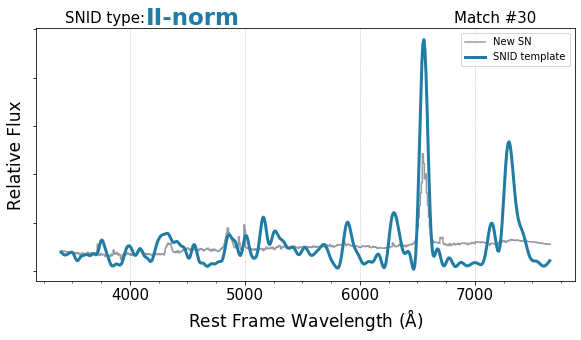

In [16]:
counter = 0
for i in sample_remaining:
    spectra_name = i["Version"].split(".")[0]
    z_snid = i["z_snid"]
    print(spectra_name)
    plot_best_5(source,output,spectra_name,z_snid, show_redshift = False)
    gc.collect()
    if(counter%20 == 0):
        print(counter)
    counter += 1

In [13]:
pngs = glob.glob(output + "/*.png")

In [15]:
len(pngs)

7710

In [17]:
len(sample_2018)*5

7715

In [25]:
glob.glob(source + "/ZTF18aaxdrjn_20180531_P60_v1/*.*")

['/home/xhall/Documents/NewZTF/sample_2018/SNIDoutput//ZTF18aaxdrjn_20180531_P60_v1/snid.param',
 '/home/xhall/Documents/NewZTF/sample_2018/SNIDoutput//ZTF18aaxdrjn_20180531_P60_v1/ZTF18aaxdrjn_20180531_P60_v1_snid.output']

In [23]:
read_tables(np.sort(glob.glob(source + "/ZTF18aaxdrjn_20180531_P60_v1/*.dat")))

IndexError: index -1 is out of bounds for axis 0 with size 0

In [27]:
glob.glob(source + "/ZTF18aabssth_20180309_P60_v1/*.dat")

[]

In [12]:
plot_best_5("/home/xhall/Documents/RandomSNID/","/home/xhall/Documents/RandomSNID/","lris20201012_ZTF20acdehpz",0.1751)

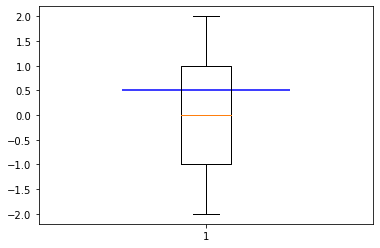

In [30]:
plt.boxplot([2 * -1, 2 * 1])
plt.hlines(.5,.75,1.25, color = "Blue")

In [31]:
files = np.sort(glob.glob(source + "ZTF17aaajnki_20180320_P60_v1/*.dat"))

In [21]:
for i in np.array(sample_2020[0]["rank_1", "rank_2", "rank_3", "rank_4", "rank_5"]):

SyntaxError: unexpected EOF while parsing (<ipython-input-21-8d04a029dbb8>, line 1)

In [30]:
rank = sample_2020[np.where(sample_2020["Version"] == "ZTF17aaajnki_20180320_P60_v1.ascii")]["rank_1", "rank_2", "rank_3", "rank_4", "rank_5"]

In [45]:
list_index = [rank["rank_1"][0] - 1, rank["rank_2"][0] - 1, rank["rank_3"][0] - 1, rank["rank_4"][0] - 1, rank["rank_5"][0] - 1]

files = np.sort(files)
matches_files = files[0:len(files)-1]
spectra = Table.read(files[-1], format = "ascii", names = ["wavelength", "flux"])
matches = []

In [46]:
matches_files[list_index]

array(['/home/xhall/Documents/NewZTF/sample_2020/SNIDoutput/ZTF17aaajnki_20180320_P60_v1/ZTF17aaajnki_20180320_P60_v1_comp0001_snidflux.dat',
       '/home/xhall/Documents/NewZTF/sample_2020/SNIDoutput/ZTF17aaajnki_20180320_P60_v1/ZTF17aaajnki_20180320_P60_v1_comp0002_snidflux.dat',
       '/home/xhall/Documents/NewZTF/sample_2020/SNIDoutput/ZTF17aaajnki_20180320_P60_v1/ZTF17aaajnki_20180320_P60_v1_comp0003_snidflux.dat',
       '/home/xhall/Documents/NewZTF/sample_2020/SNIDoutput/ZTF17aaajnki_20180320_P60_v1/ZTF17aaajnki_20180320_P60_v1_comp0005_snidflux.dat',
       '/home/xhall/Documents/NewZTF/sample_2020/SNIDoutput/ZTF17aaajnki_20180320_P60_v1/ZTF17aaajnki_20180320_P60_v1_comp0008_snidflux.dat'],
      dtype='<U131')

In [44]:
rank["rank_1"][0]

1

In [57]:
sample_2020[np.argmax(sample_2020["rank_5"])]

Version,ZTF_Name,z_sntemplate,z_rlap,z_snid,z_snid_err,z_level,rank_1,sntemplate_1,rlap_1,c_snid_1,z_snid_1,z_snid_err_1,age_1,age_flag_1,rank_2,sntemplate_2,rlap_2,c_snid_2,z_snid_2,z_snid_err_2,age_2,age_flag_2,rank_3,sntemplate_3,rlap_3,c_snid_3,z_snid_3,z_snid_err_3,age_3,age_flag_3,rank_4,sntemplate_4,rlap_4,c_snid_4,z_snid_4,z_snid_err_4,age_4,age_flag_4,rank_5,sntemplate_5,rlap_5,c_snid_5,z_snid_5,z_snid_err_5,age_5,age_flag_5
str39,str12,str12,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64
ZTF18aayyxxp_20180615_APO_v2.ascii,ZTF18aayyxxp,sn09ao,11.39,0.0176,0.0034,1,1,sn09ao,11.39,II-norm,0.0176,0.0034,49.0,0,3,sn03bn,10.02,II-norm,0.0178,0.0044,45.0,0,4,sn2005cs,9.21,II-norm,0.016,0.0036,12.7,0,20,sn2006T,8.17,IIb,0.0305,0.0076,-11.5,0,100,sn1998de,6.73,Ia-91bg,0.0369,0.0113,2.7,0


In [63]:
sample_2020[np.where(sample_2020["rank_5"] > 50)].to_pandas().to_csv("/home/xhall/Documents/NewZTF/sample_2020/SNID_2020_output_more.csv")

In [64]:
sample_2020[np.where(sample_2020["rank_5"] > 50)]

Version,ZTF_Name,z_sntemplate,z_rlap,z_snid,z_snid_err,z_level,rank_1,sntemplate_1,rlap_1,c_snid_1,z_snid_1,z_snid_err_1,age_1,age_flag_1,rank_2,sntemplate_2,rlap_2,c_snid_2,z_snid_2,z_snid_err_2,age_2,age_flag_2,rank_3,sntemplate_3,rlap_3,c_snid_3,z_snid_3,z_snid_err_3,age_3,age_flag_3,rank_4,sntemplate_4,rlap_4,c_snid_4,z_snid_4,z_snid_err_4,age_4,age_flag_4,rank_5,sntemplate_5,rlap_5,c_snid_5,z_snid_5,z_snid_err_5,age_5,age_flag_5
str39,str12,str12,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64,int64,str12,float64,str7,float64,float64,float64,int64
ZTF18aabcvnq_20180604_P60_v1.ascii,ZTF18aabcvnq,sn2005cf,6.96,0.1741,0.0084,1,1,sn2005cf,6.96,Ia-norm,0.1741,0.0084,-2.4,0,2,sn2007jg,6.92,Ia-norm,0.1868,0.009000000000000001,-2.3,0,3,sn2004S,6.37,Ia-norm,0.1721,0.0094,1.6,0,49,sn2006oa,4.9,Ia-91T,0.1729,0.0116,-3.8,0,61,sn2013dx,4.74,Ic-BL,0.0429,0.022000000000000002,19.5,0
ZTF18aabtxvd_20180411_DCT_v2.ascii,ZTF18aabtxvd,sn2005cs,12.78,0.0617,0.0048,1,1,sn2005cs,12.78,II-norm,0.0617,0.0048,0.8,0,3,sn05cs,11.51,II-norm,0.0627,0.0051,1.0,0,4,sn1999em,11.07,II-norm,0.0667,0.0059,-1.6,0,63,sn1993J,6.32,IIb,0.0696,0.0112,532.1,0,78,sn98bw,5.57,Ic-BL,0.1788,0.0129,86.9,0
ZTF18aabtxvd_20180417_Keck1_v1.ascii,ZTF18aabtxvd,sn99em,13.03,0.0669,0.0048,1,1,sn99em,13.03,II-norm,0.0669,0.0048,1.4,0,3,sn04fc,11.68,II-norm,0.0671,0.0055,9.0,0,4,sn2004et,11.49,II-norm,0.0672,0.0054,-1.9,0,21,ASASSN14ae,8.54,TDE,0.0615,0.0078,30.0,1,64,sn98bw,6.19,Ic-BL,0.0883,0.0127,11.7,0
ZTF18aabtxvd_20180419_Gemini_N_v1.ascii,ZTF18aabtxvd,sn09bz,11.85,0.0675,0.0055,1,1,sn09bz,11.85,II-norm,0.0675,0.0055,9.0,0,2,sn03iq,10.55,II-norm,0.0677,0.0062,9.0,0,3,sn08il,9.34,II-norm,0.0708,0.0069,3.0,0,79,ASASSN14ae,4.98,TDE,0.0634,0.0113,30.0,1,98,sn2012bz,4.5,Ic-BL,0.0314,0.0195,3.9,0
ZTF18aabtxvd_20180513_DCT_v1.ascii,ZTF18aabtxvd,sn06it,8.43,0.0667,0.0075,1,1,sn06it,8.43,II-norm,0.0667,0.0075,12.0,0,2,sn2004et,8.02,II-norm,0.0669,0.0077,-0.9,0,3,sn04et,8.02,II-norm,0.0669,0.0077,-0.9,0,4,ASASSN14ae,7.97,TDE,0.0622,0.0081,30.0,1,51,sn98S,6.01,IIn,0.0711,0.0097,310.1,0
ZTF18aabxlsv_20181110_Keck1_v1.ascii,ZTF18aabxlsv,sn07it,9.77,0.0468,0.0034,1,1,sn07it,9.77,II-norm,0.0468,0.0034,268.0,0,2,sn04et,9.64,II-norm,0.0468,0.0031,297.7,0,4,sn87A,9.31,II-norm,0.044000000000000004,0.0037,316.0,0,16,sn97cy,8.91,IIn,0.0497,0.0048,71.3,1,89,sn2005da,7.72,Ic-BL,0.0528,0.0105,2.0,1
ZTF18aabybkt_20180321_APO_v1.ascii,ZTF18aabybkt,sn05cs,16.07,0.0074,0.0021,1,1,sn05cs,16.07,II-norm,0.0074,0.0021,5.0,0,3,sn99br,15.65,II-norm,0.0048,0.0018,18.0,0,13,sn06Y,10.33,II-norm,0.0164,0.0035,27.0,0,45,sn2006aj,7.87,Ic-BL,0.046,0.0071,198.1,0,61,sn1998S,7.45,IIn,0.0151,0.0045,325.0,0
ZTF18aaccmnh_20180517_P200_v1.ascii,ZTF18aaccmnh,sn03bn,16.38,0.0316,0.002,1,1,sn03bn,16.38,II-norm,0.0316,0.002,95.0,0,2,sn04fc,15.74,II-norm,0.0326,0.0021,63.0,0,3,sn06it,13.85,II-norm,0.0352,0.0027,36.0,0,69,lbv03hy,9.58,LBV,0.0397,0.004,-99.9,2,84,sn1998S,9.09,IIn,0.0371,0.0041,39.7,0
ZTF18aagstdc_20180402_P60_v1.ascii,ZTF18aagstdc,sn2002dj,21.55,0.0469,0.0029,1,1,sn2002dj,21.55,Ia-norm,0.0469,0.0029,-6.4,0,2,sn2002ef,21.2,Ia-norm,0.0384,0.0027,-2.9,0,3,sn00E,21.11,Ia-norm,0.0382,0.0028,-5.5,0,15,sn2002hu,17.88,Ia-91T,0.0366,0.0031,-3.5,0,84,sn06gz,13.39,Ia-03fg,0.0399,0.0037,-2.6,0
